In [ ]:
import os
import json
import requests
import urllib
from collections import Counter

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from torchvision import transforms


from PIL import Image
from pycocotools.coco import COCO

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/Winter2025')
!pwd

/content/drive/MyDrive/Winter2025


### Step 1: Analyze and organize the dataset


In [ ]:
# paths
train_path = "/content/drive/MyDrive/Winter2025/train"
raw_path = "/content/drive/MyDrive/Winter2025/Raw"


In [ ]:
def explore_dataset_structure():
    """Explore the dataset directory structure and count files"""
    print("=== Dataset Structure ===")

    # Check Raw directory
    if os.path.exists(raw_path):
        raw_files = os.listdir(raw_path)
        print(f"Raw directory: {len(raw_files)} files")
        print(f"Sample files: {raw_files[:5] if len(raw_files) > 5 else raw_files}")
    else:
        print(f"Raw directory not found at {raw_path}")


    if os.path.exists(train_path):
        train_files = os.listdir(train_path)
        print(f"Train directory: {len(train_files)} files")
        print(f"Sample files: {train_files[:5] if len(train_files) > 5 else train_files}")
    else:
        print(f"Train directory not found at {train_path}")

    # Count image files vs annotation files
    if os.path.exists(raw_path):
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
        image_files = [f for f in raw_files if any(f.lower().endswith(ext) for ext in image_extensions)]
        print(f"Total raw images: {len(image_files)}")

    return raw_path, train_path

def find_annotation_file(train_path):
    """Find and load COCO annotation file"""
    # Common names for COCO annotation files
    potential_files = [
        os.path.join(train_path, "_annotations.coco.json"),
        os.path.join(train_path, "annotations.json"),
        os.path.join(train_path, "instances_default.json"),
        os.path.join(train_path, "coco_annotations.json")
    ]

    for file_path in potential_files:
        if os.path.exists(file_path):
            print(f"Found annotation file: {file_path}")
            return file_path

    # If no standard file found, look for any JSON file
    json_files = [f for f in os.listdir(train_path) if f.endswith('.json')]
    if json_files:
        annotation_path = os.path.join(train_path, json_files[0])
        print(f"Using JSON file as annotation: {annotation_path}")
        return annotation_path

    print("No annotation file found")
    return None

def analyze_annotations(annotation_file):
    """Analyze COCO format annotations"""
    print("\n=== Annotation Analysis ===")

    with open(annotation_file, 'r') as f:
        data = json.load(f)

    # Print basic statistics
    print(f"JSON keys: {', '.join(data.keys())}")

    if 'images' in data:
        print(f"Number of images: {len(data['images'])}")
        if len(data['images']) > 0:
            sample_image = data['images'][0]
            print(f"Sample image entry: {sample_image}")

    if 'annotations' in data:
        print(f"Number of annotations: {len(data['annotations'])}")
        if len(data['annotations']) > 0:
            sample_annotation = data['annotations'][0]
            print(f"Sample annotation entry: {sample_annotation}")

    if 'categories' in data:
        print("Categories:")
        for category in data['categories']:
            category_id = category['id']
            category_name = category.get('name', 'Unknown')
            print(f"  {category_id}: {category_name}")

    return data

def image_annotation_distribution(data):
    """Analyze distribution of annotations per image"""
    print("\n=== Annotation Distribution ===")

    if not ('images' in data and 'annotations' in data):
        print("Data doesn't contain both images and annotations")
        return

    # Count annotations per image
    image_ids = {img['id']: img['file_name'] for img in data['images']}
    annotations_per_image = Counter([ann['image_id'] for ann in data['annotations']])

    # Count how many images have each number of annotations
    distribution = Counter(annotations_per_image.values())

    print(f"Images with annotations: {len(annotations_per_image)} out of {len(image_ids)}")
    print(f"Distribution of annotations per image: {dict(sorted(distribution.items()))}")

    # Calculate percentage of labeled data
    labeled_percentage = (len(annotations_per_image) / len(image_ids)) * 100 if image_ids else 0
    print(f"Percentage of dataset that is labeled: {labeled_percentage:.2f}%")

    # Plot distribution
    plt.figure(figsize=(10, 5))
    annotation_counts = list(distribution.keys())
    image_counts = list(distribution.values())

    plt.bar(annotation_counts, image_counts)
    plt.xlabel('Number of Annotations')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Annotations per Image')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(annotation_counts)
    plt.show()

    return image_ids, annotations_per_image



def visualize_sample_annotations(data, train_path, n_samples=3):
    """Visualize a few sample images with their annotations"""
    print("\n=== Sample Visualizations ===")

    if not all(k in data for k in ['images', 'annotations']):
        print("Data doesn't contain required fields for visualization")
        return

    # Initialize COCO API
    coco = COCO()
    coco.dataset = data
    coco.createIndex()

    # Get image IDs with annotations
    image_ids_with_annotations = list(set([ann['image_id'] for ann in data['annotations']]))

    if not image_ids_with_annotations:
        print("No images with annotations found")
        return

    # Take a few random images to visualize
    n_samples = min(n_samples, len(image_ids_with_annotations))
    sample_image_ids = np.random.choice(image_ids_with_annotations, n_samples, replace=False)

    for img_id in sample_image_ids:
        # Get image info
        img_info = coco.loadImgs([img_id])[0]
        img_path = os.path.join(train_path, img_info['file_name'])

        if not os.path.exists(img_path):
            # Try to find in Raw directory
            img_path = os.path.join("/content/Dataset/Raw", img_info['file_name'])
            if not os.path.exists(img_path):
                print(f"Image not found: {img_info['file_name']}")
                continue

        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get annotations for this image
        ann_ids = coco.getAnnIds(imgIds=[img_id])
        anns = coco.loadAnns(ann_ids)

        plt.figure(figsize=(12, 8))
        plt.imshow(img)

        # Draw annotations
        for ann in anns:
            bbox = ann['bbox']  # [x, y, width, height]
            # Convert COCO format [x, y, width, height] to matplotlib [x, y, x+width, y+height]
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                                  linewidth=2, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)

            # Add label
            plt.text(bbox[0], bbox[1]-5, f"Box {ann.get('category_id', '')}",
                     color='white', fontsize=10,
                     bbox=dict(facecolor='red', alpha=0.5))

        plt.title(f"Image: {img_info['file_name']} | {len(anns)} boxes")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

def labeled_vs_unlabeled_summary(data, raw_path):
    """Create summary of labeled vs unlabeled data"""
    print("\n=== Labeled vs Unlabeled Summary ===")

    # Get all image files in Raw directory
    all_images = []
    if os.path.exists(raw_path):
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
        all_images = [f for f in os.listdir(raw_path)
                      if any(f.lower().endswith(ext) for ext in image_extensions)]

    if not all_images:
        print("No images found in Raw directory")
        return

    # Get labeled images filenames
    labeled_images = set()
    if 'images' in data:
        labeled_images = set(img['file_name'] for img in data['images'])

    # Calculate overlap
    unlabeled_images = set(all_images) - labeled_images

    print(f"Total images in dataset: {len(all_images)}")
    print(f"Labeled images: {len(labeled_images)}")
    print(f"Unlabeled images: {len(unlabeled_images)}")

    # Calculate percentages
    labeled_percentage = (len(labeled_images) / len(all_images)) * 100 if all_images else 0
    print(f"Percentage labeled: {labeled_percentage:.2f}%")
    print(f"Percentage unlabeled: {100 - labeled_percentage:.2f}%")

    # Plot pie chart
    plt.figure(figsize=(8, 6))
    plt.pie([len(labeled_images), len(unlabeled_images)],
            labels=['Labeled', 'Unlabeled'],
            autopct='%1.1f%%',
            colors=['#66b3ff', '#ffcc99'],
            startangle=90)
    plt.title('Dataset Composition')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    return labeled_images, unlabeled_images

# Main function to run the complete EDA
def run_eda():
    """Run the complete exploratory data analysis"""
    # Explore dataset structure
    raw_path, train_path = explore_dataset_structure()

    # Find and load annotation file
    annotation_file = find_annotation_file(train_path)
    if not annotation_file:
        print("Cannot proceed without annotation file")
        return

    # Analyze annotations
    data = analyze_annotations(annotation_file)

    # Analyze distribution of annotations per image
    image_ids, annotations_per_image = image_annotation_distribution(data)

    # Analyze box stacks (our key safety metric)
    image_to_box_count = analyze_box_stacks(data)

    # Create summary of labeled vs unlabeled data
    labeled_images, unlabeled_images = labeled_vs_unlabeled_summary(data, raw_path)

    # Visualize sample annotations
    visualize_sample_annotations(data, train_path, n_samples=3)

    print("\n=== EDA Complete ===")
    print("Next steps:")
    print("1. Separate labeled and unlabeled images")
    print("2. Set up the semi-supervised learning framework")
    print("3. Develop a model to detect and count stacked boxes")

In [ ]:
def analyze_box_stacks(data):
    """Analyze the distribution of box stacks to identify images with >5 boxes"""
    print("\n=== Box Stack Analysis ===")

    if 'annotations' not in data:
        print("Data doesn't contain annotations")
        return

    # Analyze annotations to identify stacks
    # This is a simplified approach

    # we'll count annotations per image as a proxy for box count
    image_to_box_count = {}
    for ann in data['annotations']:
        image_id = ann['image_id']
        if image_id not in image_to_box_count:
            image_to_box_count[image_id] = 0
        image_to_box_count[image_id] += 1

    # Count images with more than 5 boxes
    images_with_more_than_5_boxes = sum(1 for count in image_to_box_count.values() if count > 5)
    print(f"Images with more than 5 boxes: {images_with_more_than_5_boxes}")
    print(f"Percentage of labeled images with >5 boxes: {(images_with_more_than_5_boxes / len(image_to_box_count)) * 100:.2f}%")

    # Calculate statistics
    box_counts = list(image_to_box_count.values())
    print(f"Average boxes per image: {np.mean(box_counts):.2f}")
    print(f"Median boxes per image: {np.median(box_counts):.2f}")
    print(f"Min boxes per image: {np.min(box_counts)}")
    print(f"Max boxes per image: {np.max(box_counts)}")

    # Plot distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(box_counts, bins=max(10, max(box_counts)), kde=True)
    plt.axvline(x=5, color='r', linestyle='--', label='Safety Threshold (5 boxes)')
    plt.xlabel('Number of Boxes')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Box Counts per Image')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return image_to_box_count

=== Dataset Structure ===
Raw directory: 245 files
Sample files: ['WhatsApp Image 2025-02-18 at 10.57.23.jpeg', 'WhatsApp Image 2025-02-14 at 12.10.22.jpeg', 'WhatsApp Image 2025-02-14 at 12.12.57 (1).jpeg', 'WhatsApp Image 2025-02-14 at 12.10.23 (1).jpeg', 'WhatsApp Image 2025-02-14 at 12.12.10 (1).jpeg']
Train directory: 406 files
Sample files: ['WhatsApp-Image-2025-02-14-at-12_10_43-1-_jpeg.rf.ab105b4f5ae50e76c43ccd731a468d9c.jpg', 'WhatsApp-Image-2025-02-18-at-10_56_18_jpeg.rf.c68b6d7d8445f2f82fcf9baf6785a8d4.jpg', 'WhatsApp-Image-2025-02-14-at-12_10_46-1-_jpeg.rf.81e279dc692eaf28079449fa3192d23a.jpg', 'WhatsApp-Image-2025-02-14-at-12_10_24-1-_jpeg.rf.965d18d13bba98b75524b0bb3dbd2249.jpg', 'WhatsApp-Image-2025-02-18-at-10_55_53-1-_jpeg.rf.0b8b1e600c460b124abc019d8f89bee1.jpg']
Total raw images: 245
Found annotation file: /content/drive/MyDrive/Winter2025/train/_annotations.coco.json

=== Annotation Analysis ===
JSON keys: info, licenses, categories, images, annotations
Number of im

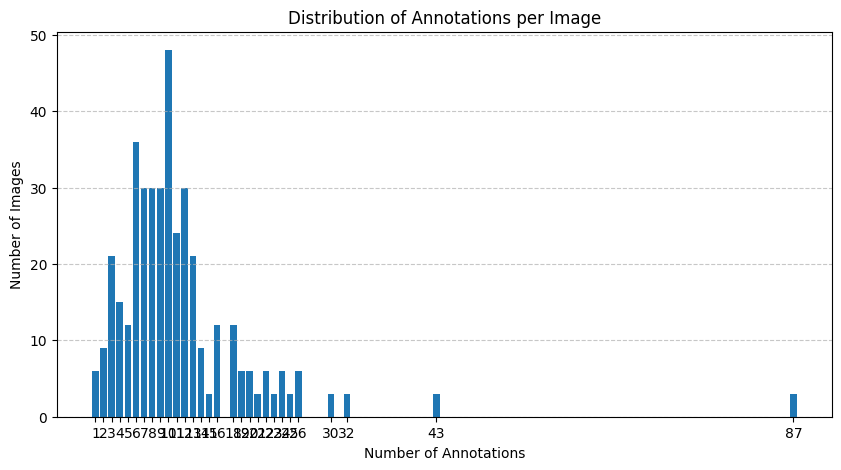


=== Box Stack Analysis ===
Images with more than 5 boxes: 336
Percentage of labeled images with >5 boxes: 84.21%
Average boxes per image: 11.40
Median boxes per image: 10.00
Min boxes per image: 1
Max boxes per image: 87


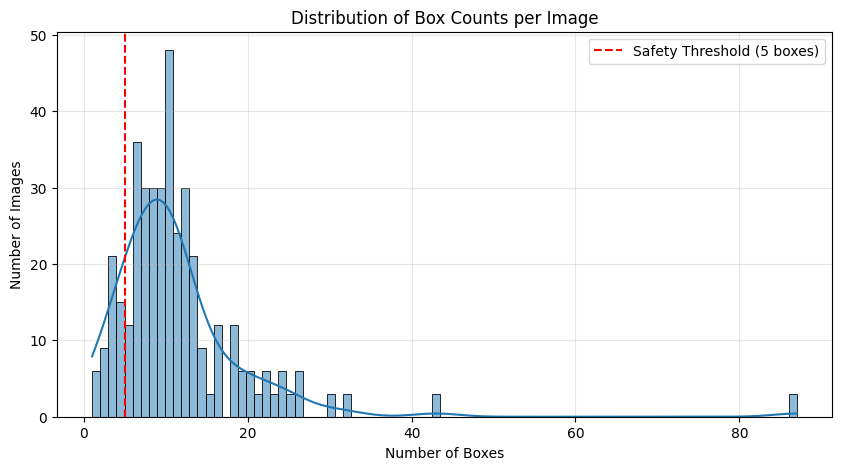


=== Labeled vs Unlabeled Summary ===
Total images in dataset: 245
Labeled images: 405
Unlabeled images: 245
Percentage labeled: 165.31%
Percentage unlabeled: -65.31%


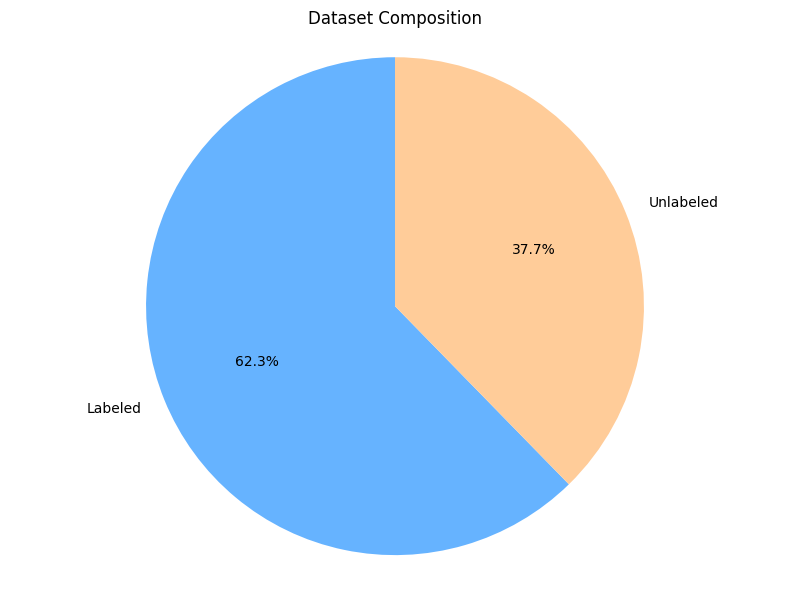


=== Sample Visualizations ===
creating index...
index created!


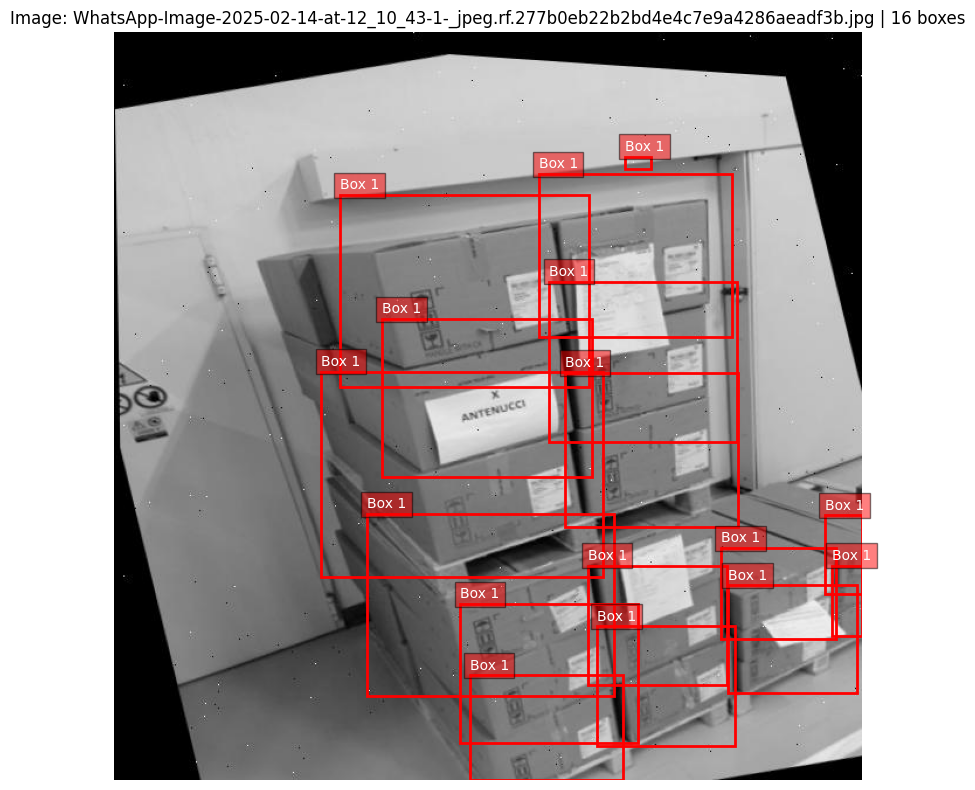

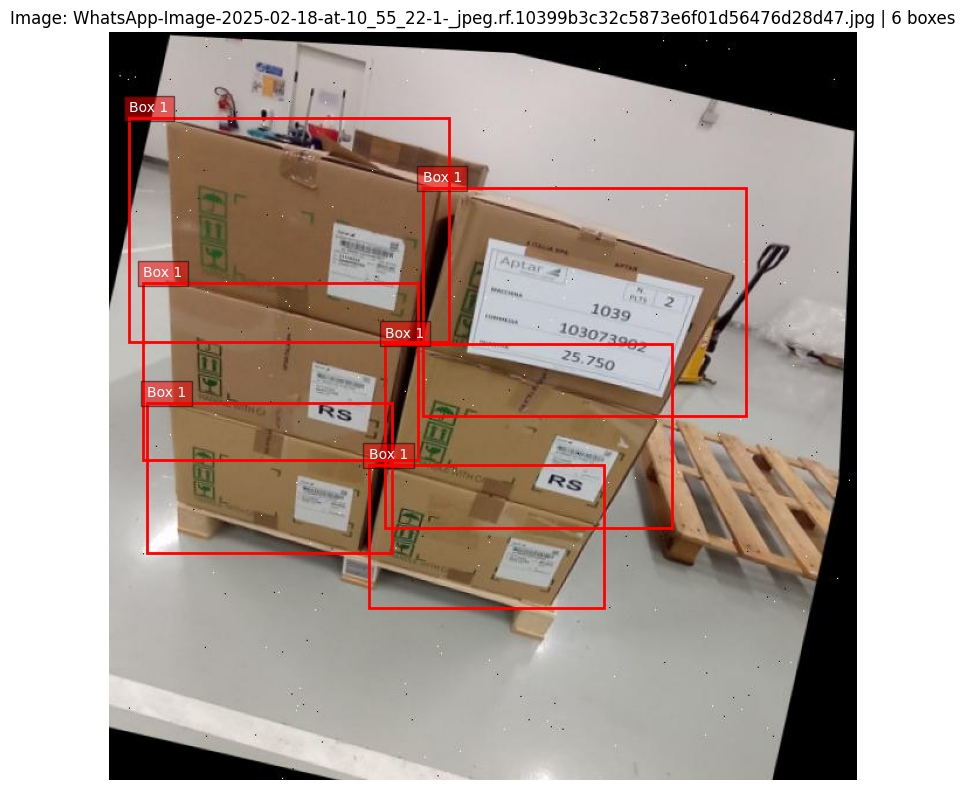

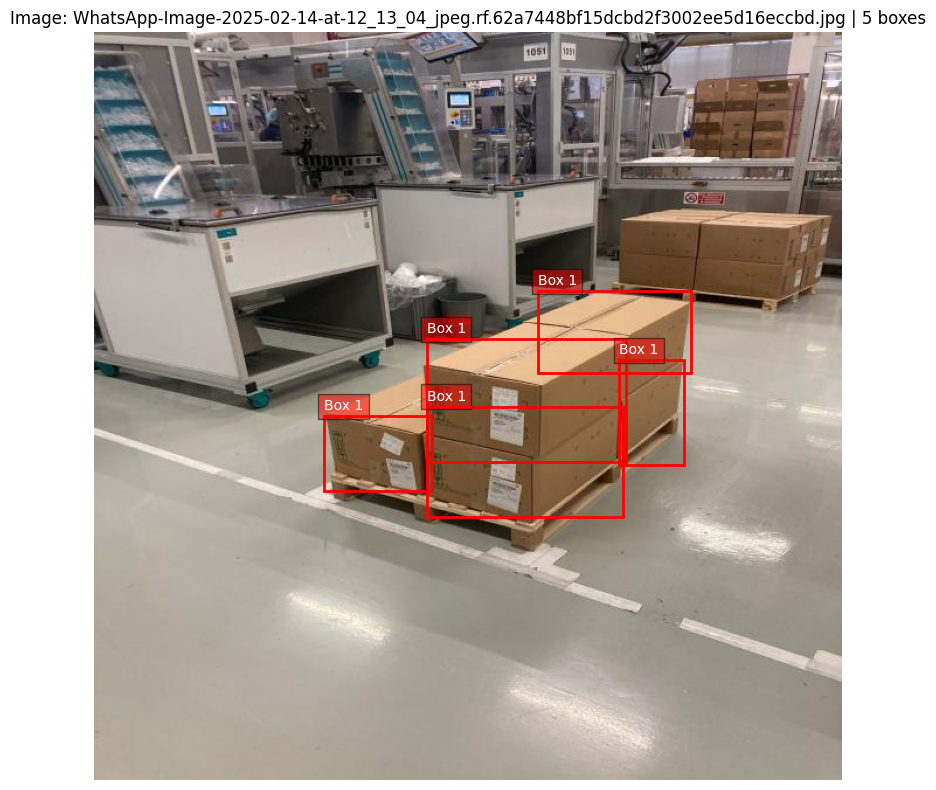


=== EDA Complete ===
Next steps:
1. Separate labeled and unlabeled images
2. Set up the semi-supervised learning framework
3. Develop a model to detect and count stacked boxes


In [ ]:
run_eda()

In [ ]:
class BoxStackDetector:
    def __init__(self, annotation_file, image_dir):
        """
        Initialize the box stack detector

        Args:
            annotation_file (str): Path to COCO annotation file
            image_dir (str): Directory containing the images
        """
        self.annotation_file = annotation_file
        self.image_dir = image_dir

        # Load COCO annotations
        with open(annotation_file, 'r') as f:
            self.annotation_data = json.load(f)

        # Initialize COCO API
        self.coco = COCO()
        self.coco.dataset = self.annotation_data
        self.coco.createIndex()

        # Map image IDs to file names for convenience
        self.image_id_to_filename = {img['id']: img['file_name'] for img in self.annotation_data['images']}

        print(f"Loaded {len(self.annotation_data['images'])} images and {len(self.annotation_data['annotations'])} annotations")

    def detect_stacks(self, overlap_threshold=0.4, vertical_tolerance=0.3):
        """
        Detect stacks of boxes in all images

        Args:
            overlap_threshold (float): Threshold for horizontal overlap between boxes
            vertical_tolerance (float): Tolerance for considering boxes in the same vertical column

        Returns:
            dict: Dictionary mapping image_id to maximum stack height
        """
        results = {}

        for img_id in self.coco.getImgIds():
            max_stack_height = self.detect_stacks_in_image(img_id, overlap_threshold, vertical_tolerance)
            results[img_id] = max_stack_height

        return results

    def detect_stacks_in_image(self, img_id, overlap_threshold=0.3, vertical_tolerance=0.2):
        """
        Detect stacks of boxes in a single image

        Args:
            img_id: Image ID
            overlap_threshold (float): Threshold for horizontal overlap between boxes
            vertical_tolerance (float): Tolerance for considering boxes in the same vertical column

        Returns:
            int: Maximum stack height
        """
        # Get annotations for this image
        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)

        if not anns:
            return 0

        # Extract bounding boxes
        boxes = []
        for ann in anns:
            # COCO format: [x, y, width, height]
            x, y, w, h = ann['bbox']
            # Convert to [x1, y1, x2, y2] format
            boxes.append([x, y, x + w, y + h])

        boxes = np.array(boxes)

        # If there are no boxes, return 0
        if len(boxes) == 0:
            return 0

        # If there is only one box, the stack height is 1
        if len(boxes) == 1:
            return 1

        # Find stacks by grouping boxes that are vertically aligned
        stacks = self._identify_vertical_stacks(boxes, overlap_threshold, vertical_tolerance)

        # Get the maximum stack height
        max_stack_height = max([len(stack) for stack in stacks]) if stacks else 0

        return max_stack_height

    def _identify_vertical_stacks(self, boxes, overlap_threshold=0.3, vertical_tolerance=0.2):
        """
        Group boxes into vertical stacks based on horizontal overlap

        Args:
            boxes (np.array): Array of boxes in format [x1, y1, x2, y2]
            overlap_threshold (float): Threshold for horizontal overlap between boxes
            vertical_tolerance (float): Tolerance for considering boxes in the same vertical column

        Returns:
            list: List of stacks, each stack is a list of box indices
        """
        n = len(boxes)

        # Calculate horizontal overlap between all pairs of boxes
        horizontal_overlap = np.zeros((n, n))
        for i in range(n):
            for j in range(i+1, n):
                box_i = boxes[i]
                box_j = boxes[j]

                # Calculate horizontal overlap
                x_overlap = max(0, min(box_i[2], box_j[2]) - max(box_i[0], box_j[0]))
                x_union = min(
                    box_i[2] - box_i[0],  # width of box i
                    box_j[2] - box_j[0]   # width of box j
                )

                # Calculate horizontal center similarity
                center_i_x = (box_i[0] + box_i[2]) / 2
                center_j_x = (box_j[0] + box_j[2]) / 2

                # Check if centers are close enough horizontally
                centers_close = abs(center_i_x - center_j_x) < vertical_tolerance * max(
                    box_i[2] - box_i[0],
                    box_j[2] - box_j[0]
                )

                # Set overlap value based on horizontal overlap ratio or center proximity
                if x_union > 0 and (x_overlap / x_union >= overlap_threshold or centers_close):
                    horizontal_overlap[i, j] = 1
                    horizontal_overlap[j, i] = 1

        # Group boxes that have sufficient horizontal overlap
        stacks = []
        visited = set()

        for i in range(n):
            if i in visited:
                continue

            # Start a new stack
            stack = [i]
            visited.add(i)

            # Find all boxes that have horizontal overlap with the current stack
            for j in range(n):
                if j in visited:
                    continue

                # Check if box j has horizontal overlap with any box in the current stack
                if any(horizontal_overlap[k, j] > 0 for k in stack):
                    stack.append(j)
                    visited.add(j)

            stacks.append(stack)

        # Sort boxes within each stack by vertical position (top to bottom)
        sorted_stacks = []
        for stack in stacks:
            # Sort by y-coordinate (top-left corner)
            sorted_stack = sorted(stack, key=lambda i: boxes[i][1])

            # Verify this is actually a stack (boxes are above each other)
            is_valid_stack = True
            for i in range(len(sorted_stack)-1):
                box1_idx = sorted_stack[i]
                box2_idx = sorted_stack[i+1]

                # Check if box2 is below box1
                if boxes[box2_idx][1] < boxes[box1_idx][3]:
                    # There's vertical overlap, indicating these may be side-by-side boxes
                    # Get the vertical overlap
                    y_overlap = min(boxes[box1_idx][3], boxes[box2_idx][3]) - max(boxes[box1_idx][1], boxes[box2_idx][1])
                    y_union = max(boxes[box1_idx][3], boxes[box2_idx][3]) - min(boxes[box1_idx][1], boxes[box2_idx][1])

                    # If overlap is significant, these are not stacked
                    if y_overlap / y_union > 0.5:
                        is_valid_stack = False
                        break

            if is_valid_stack and len(sorted_stack) > 0:
                sorted_stacks.append([boxes[i] for i in sorted_stack])

        return sorted_stacks

    def visualize_stacks(self, img_id, overlap_threshold=0.3, vertical_tolerance=0.2, save_path=None):
        """
        Visualize detected stacks in an image

        Args:
            img_id: Image ID
            overlap_threshold (float): Threshold for horizontal overlap
            vertical_tolerance (float): Tolerance for vertical alignment
            save_path (str): Path to save the visualization
        """
        img_info = self.coco.loadImgs([img_id])[0]
        img_path = os.path.join(self.image_dir, img_info['file_name'])

        # Generates from custom path if coco annotation path is not valid
        # In our case, since we uploaded to Colab, the path is different
        if not os.path.exists(img_path):
            alt_path = os.path.join("./Dataset/Raw", img_info['file_name'])
            if os.path.exists(alt_path):
                img_path = alt_path

        # Load image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error: Could not load image {img_path}")
            return

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get annotations
        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)

        # Extract bounding boxes
        boxes = []
        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])

        boxes = np.array(boxes)

        # Identify stacks
        # We try to check vertical alignment with Thresholds
        stacks = self._identify_vertical_stacks(boxes, overlap_threshold, vertical_tolerance)

        # Plot image
        plt.figure(figsize=(12, 8))
        plt.imshow(img)

        # Colors for different stacks
        colors = plt.cm.rainbow(np.linspace(0, 1, len(stacks)))

        # Draw original bounding boxes
        for ann in anns:
            bbox = ann['bbox']  # [x, y, width, height]
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                                linewidth=1, edgecolor='gray', facecolor='none')
            plt.gca().add_patch(rect)

        # Draw stacks with different colors
        for stack_idx, stack in enumerate(stacks):
            color = colors[stack_idx]

            # Draw boxes in this stack
            for box_idx, box in enumerate(stack):
                rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                    linewidth=2, edgecolor=color, facecolor='none')
                plt.gca().add_patch(rect)

                # Add stack and position label
                plt.text(box[0], box[1]-5, f"S{stack_idx+1}:{box_idx+1}",
                        color='white', fontsize=10,
                        bbox=dict(facecolor=color, alpha=0.7))

        # Add title with max stack height
        max_stack_height = max([len(stack) for stack in stacks]) if stacks else 0
        plt.title(f"Image: {img_info['file_name']} | Max Stack Height: {max_stack_height}")

        if max_stack_height > 5:
            plt.figtext(0.5, 0.01, "WARNING: Stack height exceeds safety threshold (5)",
                       color='red', fontsize=14, ha='center',
                       bbox=dict(facecolor='yellow', alpha=0.5))

        plt.axis('off')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Visualization saved to {save_path}")

        plt.show()

    def analyze_all_stacks(self):
        """
        Analyze stack heights across all images

        Returns:
            dict: Dictionary with stack height statistics and safety analysis
        """
        # Detect stacks in all images
        stack_heights = self.detect_stacks()

        # Calculate statistics
        heights = list(stack_heights.values())

        stats = {
            "total_images": len(heights),
            "max_stack_height": max(heights) if heights else 0,
            "min_stack_height": min(heights) if heights else 0,
            "avg_stack_height": np.mean(heights) if heights else 0,
            "median_stack_height": np.median(heights) if heights else 0,
            "unsafe_images": sum(1 for h in heights if h > 5),
            "unsafe_percentage": (sum(1 for h in heights if h > 5) / len(heights)) * 100 if heights else 0
        }

        # Create histogram of stack heights
        plt.figure(figsize=(10, 6))
        bins = np.arange(0, max(heights) + 2) - 0.5 if heights else [0, 1]
        plt.hist(heights, bins=bins, alpha=0.7, color='#66b3ff')
        plt.axvline(x=5.5, color='r', linestyle='--', label='Safety Threshold (5 boxes)')
        plt.xlabel('Maximum Stack Height')
        plt.ylabel('Number of Images')
        plt.title('Distribution of Maximum Stack Heights')
        plt.xticks(range(0, max(heights) + 1) if heights else [0])
        plt.grid(alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

        print("\n=== Stack Height Analysis ===")
        print(f"Total images analyzed: {stats['total_images']}")
        print(f"Maximum stack height: {stats['max_stack_height']}")
        print(f"Minimum stack height: {stats['min_stack_height']}")
        print(f"Average stack height: {stats['avg_stack_height']:.2f}")
        print(f"Median stack height: {stats['median_stack_height']}")
        print(f"Images with unsafe stacks (>5 boxes): {stats['unsafe_images']} ({stats['unsafe_percentage']:.2f}%)")

        # List images with unsafe stacks
        unsafe_images = [img_id for img_id, height in stack_heights.items() if height > 5]
        if unsafe_images:
            print("\nUnsafe Images:")
            for img_id in unsafe_images[:10]:  # Show only the first 10
                print(f"- {self.image_id_to_filename[img_id]} (Stack height: {stack_heights[img_id]})")

            if len(unsafe_images) > 10:
                print(f"... and {len(unsafe_images) - 10} more")

        return stats, stack_heights, unsafe_images

def show_stacks_stat():
    annotation_file = train_path + "/_annotations.coco.json"
    image_dir = train_path

    # Create detector
    detector = BoxStackDetector(annotation_file, image_dir)

    # Analyze all stacks
    stats, stack_heights, unsafe_images = detector.analyze_all_stacks()

    # Visualize a few images with stacks
    # Start with unsafe images if any
    print("\n=== Visualizing sample images ===")

    # Visualizing up to 3 safe images
    safe_images = [img_id for img_id, height in stack_heights.items() if height <= 5]
    if safe_images:
        print("Visualizing safe images (stack height <= 5):")
        for img_id in safe_images[:3]:
            detector.visualize_stacks(img_id)

    # Visualize up to 3 unsafe images
    if unsafe_images:
        print("Visualizing unsafe images (stack height > 5):")
        for img_id in unsafe_images[:3]:
            detector.visualize_stacks(img_id)

    # Visualize a few random images if needed
    if len(unsafe_images) < 3:
        remaining = 3 - len(unsafe_images)
        safe_images = [img_id for img_id, height in stack_heights.items() if height <= 5]
        if safe_images:
            print("\nVisualizing safe images (stack height <= 5):")
            import random
            for img_id in random.sample(safe_images, min(remaining, len(safe_images))):
                detector.visualize_stacks(img_id)


creating index...
index created!
Loaded 59 images and 544 annotations


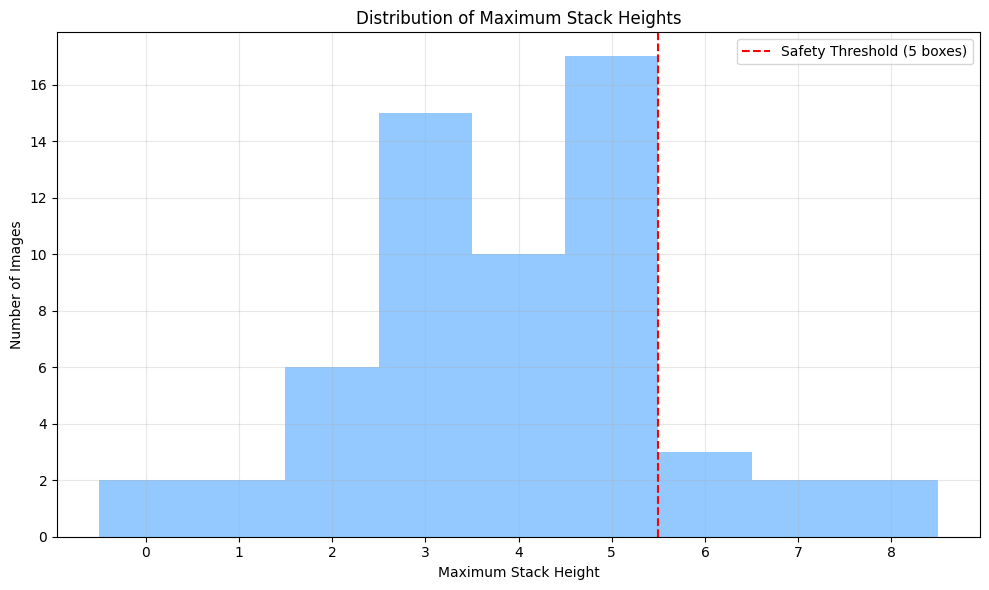


=== Stack Height Analysis ===
Total images analyzed: 59
Maximum stack height: 8
Minimum stack height: 0
Average stack height: 3.93
Median stack height: 4.0
Images with unsafe stacks (>5 boxes): 7 (11.86%)

Unsafe Images:
- WhatsApp-Image-2025-02-14-at-12_13_01-1-_jpeg.rf.23c47098ff61005c6f57b6cf6b1a5ecd.jpg (Stack height: 6)
- WhatsApp-Image-2025-02-18-at-15_10_12-3-_jpeg.rf.28938c4712a1674a5533de54bc0ea3db.jpg (Stack height: 6)
- WhatsApp-Image-2025-02-14-at-12_10_39_jpeg.rf.0e10f817832965c98282634ff0b115b5.jpg (Stack height: 7)
- WhatsApp-Image-2025-02-14-at-12_12_26-2-_jpeg.rf.6243efa523000fe4cd446f956df39e50.jpg (Stack height: 7)
- WhatsApp-Image-2025-02-18-at-15_10_14_jpeg.rf.a7892188591120af485285389df5aef7.jpg (Stack height: 8)
- WhatsApp-Image-2025-02-18-at-10_56_33_jpeg.rf.cda16042be5bb4f34f0aada29569cb67.jpg (Stack height: 6)
- WhatsApp-Image-2025-02-18-at-10_55_30_jpeg.rf.fbd91a18f454de96fecd984497aade67.jpg (Stack height: 8)

=== Visualizing sample images ===
Visualizing s

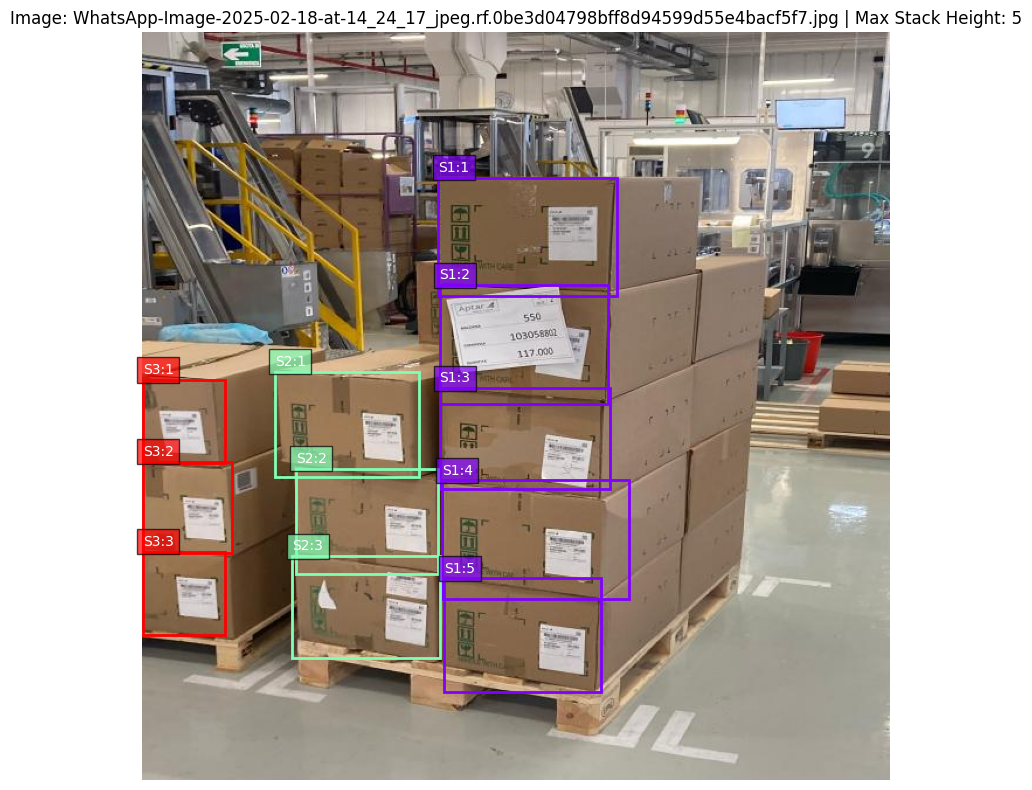

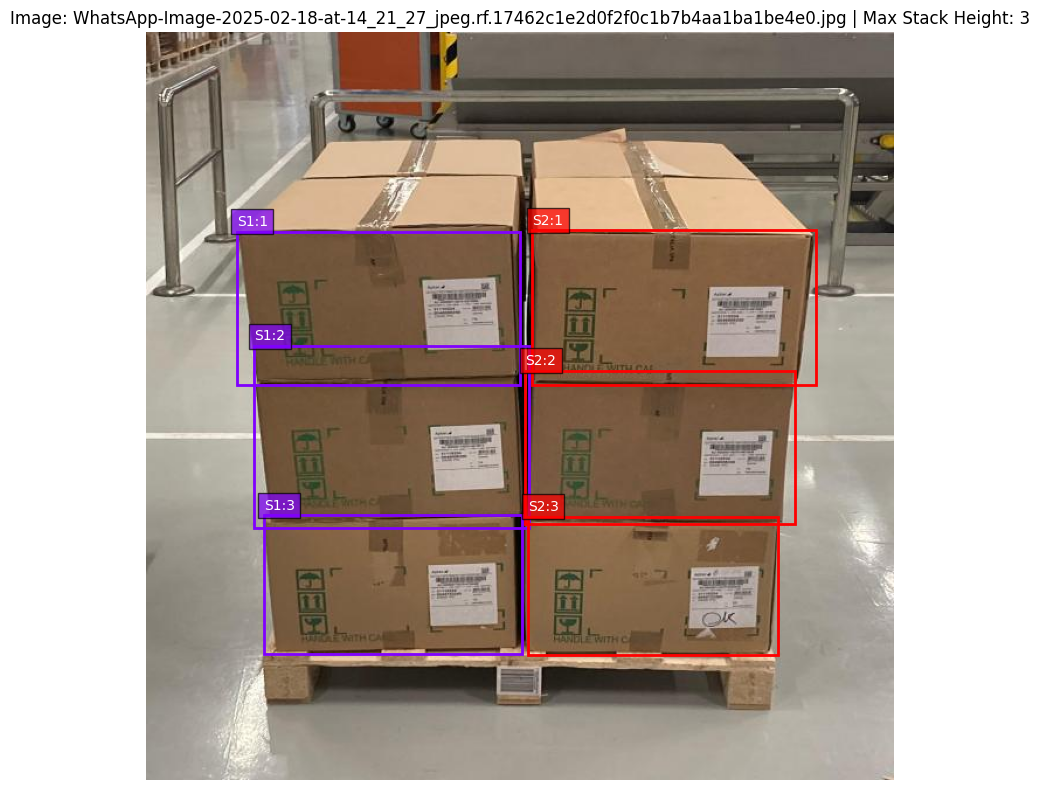

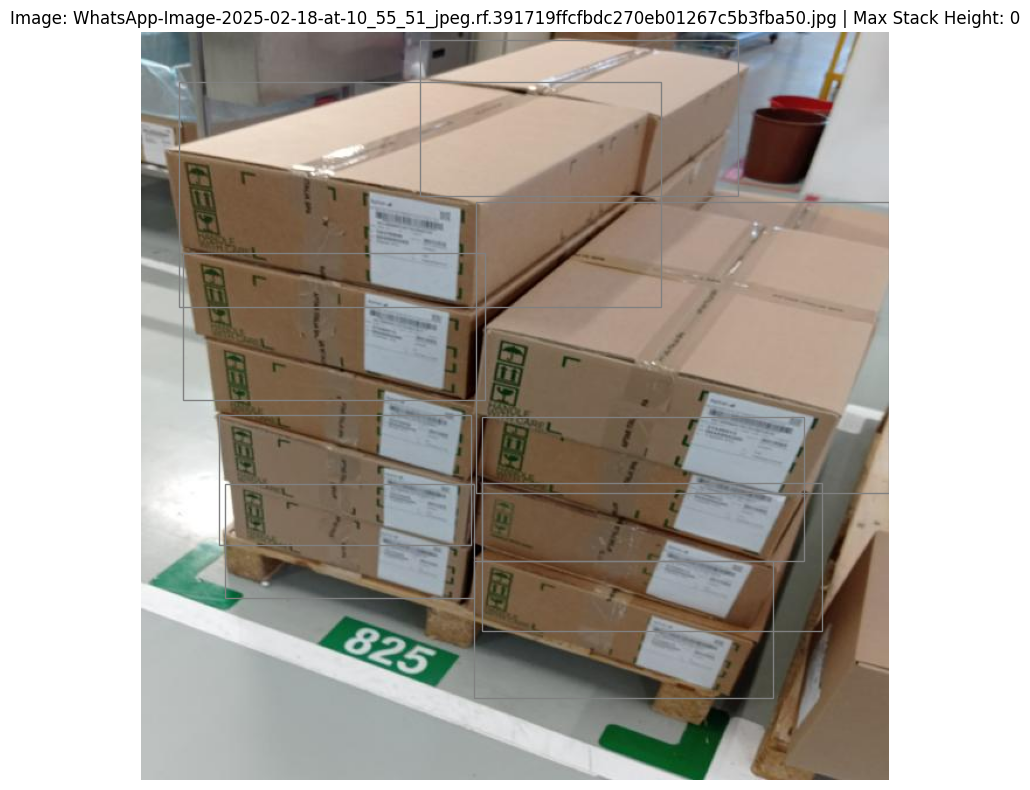

Visualizing unsafe images (stack height > 5):


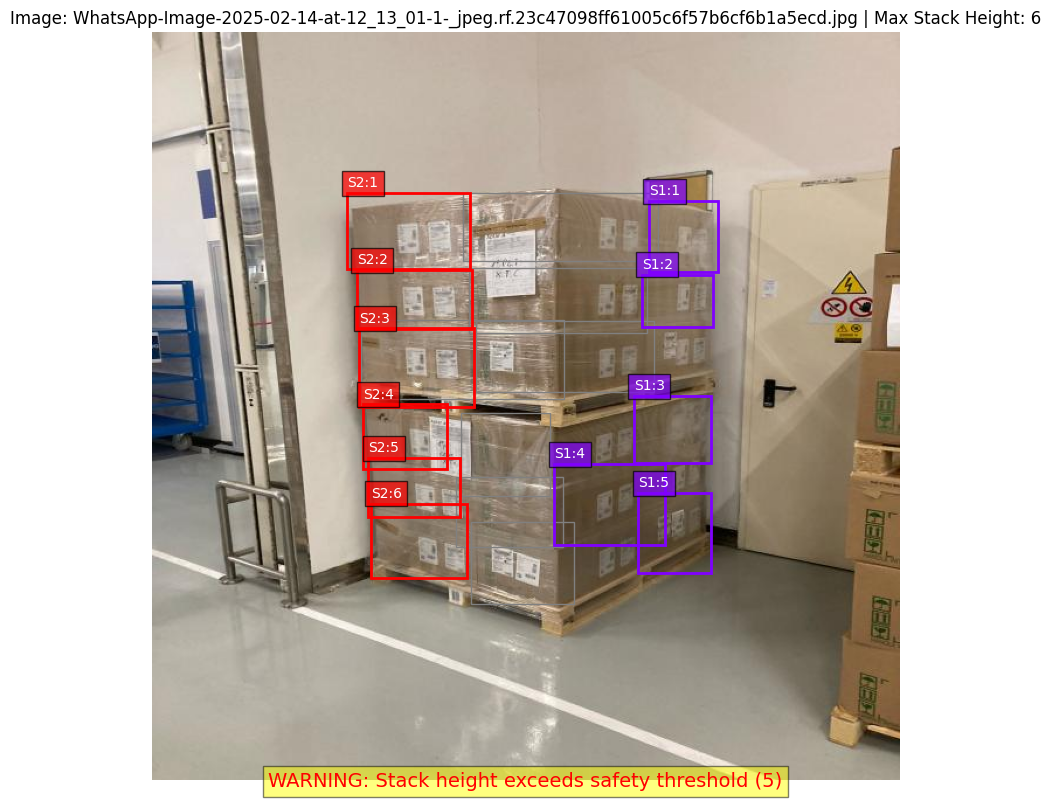

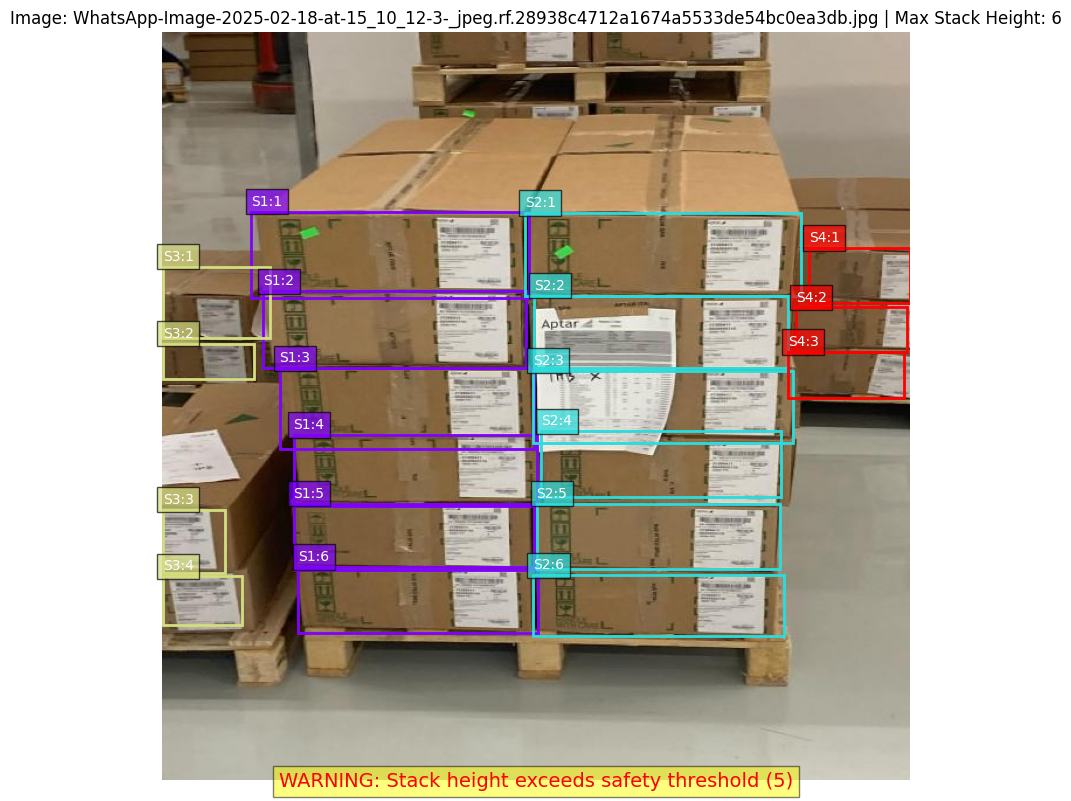

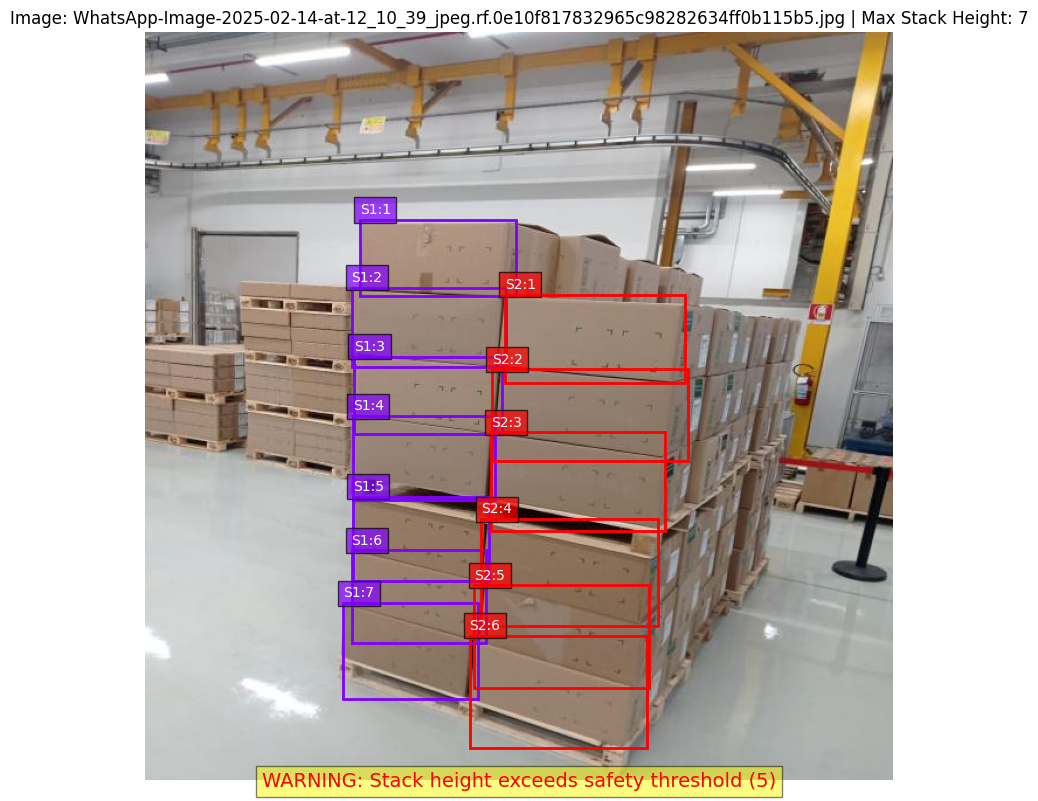

In [ ]:
show_stacks_stat()

### Semi-Supervised Labelling

In [ ]:
from PIL import Image, ImageDraw, ImageFont
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

from collections import defaultdict

In [ ]:
class BoxDataset(Dataset):
    """
    Dataset for labeled box images with annotations
    """

    def __init__(self, annotation_file, image_dir, transform=None):
        """
        Args:
            annotation_file (str): Path to COCO annotation file
            image_dir (str): Directory containing the images
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.image_dir = image_dir
        self.transform = transform

        # Load COCO annotations
        self.coco = COCO(annotation_file)
        self.img_ids = list(sorted(self.coco.imgs.keys()))

        # Map image IDs to their annotations
        self.img_to_anns = defaultdict(list)
        for ann in self.coco.dataset["annotations"]:
            self.img_to_anns[ann["image_id"]].append(ann)

        # Get image IDs that have annotations
        self.labeled_img_ids = [
            img_id for img_id in self.img_ids if len(self.img_to_anns[img_id]) > 0
        ]

        print(f"Loaded {len(self.labeled_img_ids)} labeled images")

    def __len__(self):
        return len(self.labeled_img_ids)

    def __getitem__(self, idx):
        """
        Get dataset item

        Args:
            idx (int): Index

        Returns:
            tuple: (image, target) where target is a binary label indicating if the image has
                   more than 5 boxes in any stack
        """
        # Get image ID and info
        img_id = self.labeled_img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]

        # Load image
        img_path = os.path.join(self.image_dir, img_info["file_name"])
        image = Image.open(img_path).convert("RGB")

        # Get annotations for this image
        annotations = self.img_to_anns[img_id]

        # Count boxes in this image
        num_boxes = len(annotations)

        # Create a binary label: 1 if there are more than 5 boxes, 0 otherwise
        # Note: In a more sophisticated version, you would use the stack detection algorithm
        # to determine if there are more than 5 boxes in any stack
        target = 1 if num_boxes > 5 else 0

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, target


class UnlabeledBoxDataset(Dataset):
    """
    Dataset for unlabeled box images
    """

    def __init__(self, image_dir, transform=None, labeled_image_names=None):
        """
        Args:
            image_dir (str): Directory containing the images
            transform (callable, optional): Optional transform to be applied on a sample
            labeled_image_names (set, optional): Set of already labeled image filenames to exclude
        """
        self.image_dir = image_dir
        self.transform = transform

        # Get all image files
        self.image_files = []
        for filename in os.listdir(image_dir):
            if filename.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
                # Skip if already labeled
                if labeled_image_names and filename in labeled_image_names:
                    continue
                self.image_files.append(filename)

        print(f"Found {len(self.image_files)} unlabeled images")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Get dataset item

        Args:
            idx (int): Index

        Returns:
            tuple: (image, filename) where filename is used for identification
        """
        # Get image filename
        filename = self.image_files[idx]

        # Load image
        img_path = os.path.join(self.image_dir, filename)
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, filename


def get_transforms(img_size=640):
    """
    Get transforms for data preprocessing and augmentation

    Args:
        img_size (int): Target image size

    Returns:
        dict: Dictionary of transforms
    """
    # Define transforms for training, validation, and unlabeled data
    data_transforms = {
        "train": transforms.Compose(
            [
                transforms.Resize((img_size, img_size)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        ),
        "val": transforms.Compose(
            [
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        ),
        "unlabeled": transforms.Compose(
            [
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        ),
    }

    return data_transforms


def setup_dataloaders(
    annotation_file, train_dir, raw_dir, batch_size=16, val_split=0.2, num_workers=4
):
    """
    Set up dataloaders for labeled and unlabeled data

    Args:
        annotation_file (str): Path to COCO annotation file
        train_dir (str): Directory containing the labeled training images
        raw_dir (str): Directory containing all raw images (including unlabeled)
        batch_size (int): Batch size
        val_split (float): Validation split ratio
        num_workers (int): Number of worker threads for loading data

    Returns:
        tuple: (labeled_train_loader, labeled_val_loader, unlabeled_loader)
    """
    # Get transforms
    transforms_dict = get_transforms()

    # Create labeled dataset
    labeled_dataset = BoxDataset(
        annotation_file=annotation_file,
        image_dir=train_dir,
        transform=transforms_dict["train"],
    )

    # Get labeled image filenames to exclude from unlabeled dataset
    labeled_filenames = set()
    for img_id in labeled_dataset.labeled_img_ids:
        img_info = labeled_dataset.coco.loadImgs(img_id)[0]
        labeled_filenames.add(img_info["file_name"])

    # Split labeled dataset into train and validation
    train_size = int((1 - val_split) * len(labeled_dataset))
    val_size = len(labeled_dataset) - train_size

    train_dataset, val_dataset = random_split(
        labeled_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42),  # for reproducibility
    )

    # Override transforms for validation dataset
    val_dataset.dataset.transform = transforms_dict["val"]

    # Create unlabeled dataset
    unlabeled_dataset = UnlabeledBoxDataset(
        image_dir=raw_dir,
        transform=transforms_dict["unlabeled"],
        labeled_image_names=labeled_filenames,
    )

    # Create dataloaders
    labeled_train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    labeled_val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    unlabeled_loader = DataLoader(
        unlabeled_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    print(f"Created dataloaders with:")
    print(f"  - {len(train_dataset)} training samples")
    print(f"  - {len(val_dataset)} validation samples")
    print(f"  - {len(unlabeled_dataset)} unlabeled samples")

    return labeled_train_loader, labeled_val_loader, unlabeled_loader




In [ ]:
# Paths
annotation_file = "./Train/_annotations.coco.json"
train_dir = "./Train"
raw_dir = "./Raw"

# Set up dataloaders with num_workers set to 0
labeled_train_loader, labeled_val_loader, unlabeled_loader = setup_dataloaders(
    annotation_file=annotation_file,
    train_dir=train_dir,
    raw_dir=raw_dir,
    batch_size=2,
    num_workers=0,
)

# Inspect a batch from the labeled dataloader
images, labels = next(iter(labeled_train_loader))
print(f"Labeled batch shape: {images.shape}")
print(f"Labels in batch: {labels}")

# Inspect a batch from the unlabeled dataloader
images, filenames = next(iter(unlabeled_loader))
print(f"Unlabeled batch shape: {images.shape}")
print(f"Sample filenames: {filenames[:3]}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loaded 59 labeled images
Found 245 unlabeled images
Created dataloaders with:
  - 47 training samples
  - 12 validation samples
  - 245 unlabeled samples
Labeled batch shape: torch.Size([2, 3, 640, 640])
Labels in batch: tensor([1, 0])
Unlabeled batch shape: torch.Size([2, 3, 640, 640])
Sample filenames: ['WhatsApp Image 2025-02-14 at 12.10.24.jpeg', 'WhatsApp Image 2025-02-18 at 10.56.02 (2).jpeg']


In [ ]:

model = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnext101_32x16d_swsl')
#backbone = resnet_fpn_backbone('resnext101_32x8d', pretrained=True)
#model = FasterRCNN(backbone, num_classes=2)

# The original model has a fc layer for 1000 ImageNet classes
# We replace it with a single output node for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Binary classification (box or no box)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.train()

Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:


labeled_loader = labeled_train_loader
num_epochs = 3



criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in labeled_loader:
        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)  # This will be logits (pre-sigmoid)

        # Compute loss - BCEWithLogitsLoss applies sigmoid internally
        loss = criterion(outputs.view(-1), labels.float())

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()

        # Calculate accuracy
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels.float()).sum().item()

    # Print epoch statistics
    epoch_loss = running_loss / len(labeled_loader)
    epoch_acc = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%')

# Save the model
torch.save(model.state_dict(), 'box_detector_model.pth')
print("Training complete. Model saved to box_detector_model.pth")


Epoch 1/3, Loss: 0.4596, Acc: 82.98%
Epoch 2/3, Loss: 0.4250, Acc: 82.98%
Epoch 3/3, Loss: 0.3765, Acc: 85.11%
Training complete. Model saved to box_detector_model.pth


In [ ]:
model.eval()  # Set model to evaluation mode
val_correct = 0
val_total = 0

with torch.no_grad():
    for images, labels in labeled_val_loader:  # Your validation dataloader
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()

        val_total += labels.size(0)
        val_correct += (predicted == labels.float()).sum().item()

val_acc = 100 * val_correct / val_total
print(f'Validation Accuracy: {val_acc:.2f}%')

Validation Accuracy: 58.33%


In [ ]:
model.eval()  # Ensure model is in evaluation mode
pseudo_labels = []
high_confidence_images = []
confidence_threshold = 0.8  # Higher threshold for reliable pseudo-labels

with torch.no_grad():
    for images, filenames in unlabeled_loader:  # Your unlabeled dataloader
        # Move images to GPU
        images = images.to(device)

        # Forward pass
        outputs = model(images)
        probs = torch.sigmoid(outputs.view(-1))

        # Get predictions and confidence
        preds = (probs > 0.5).float()

        # Select samples with high confidence
        # High confidence means either very close to 0 or very close to 1
        confidence = torch.max(probs, 1-probs)
        mask = confidence > confidence_threshold

        if mask.sum() > 0:
            # Store high confidence predictions
            high_confidence_images.append(images[mask].cpu())
            pseudo_labels.append(preds[mask].cpu())

            # Print some statistics about pseudo-labels
            num_positives = preds[mask].sum().item()
            num_samples = mask.sum().item()
            print(f"Generated {num_samples} pseudo-labels: {num_positives} positives, {num_samples - num_positives} negatives")

print(f"Total pseudo-labeled images: {sum(len(labels) for labels in pseudo_labels)}")

Generated 1 pseudo-labels: 1.0 positives, 0.0 negatives
Generated 1 pseudo-labels: 1.0 positives, 0.0 negatives
Generated 1 pseudo-labels: 1.0 positives, 0.0 negatives
Generated 1 pseudo-labels: 1.0 positives, 0.0 negatives
Generated 1 pseudo-labels: 1.0 positives, 0.0 negatives
Generated 1 pseudo-labels: 1.0 positives, 0.0 negatives
Generated 1 pseudo-labels: 1.0 positives, 0.0 negatives
Generated 1 pseudo-labels: 1.0 positives, 0.0 negatives
Generated 1 pseudo-labels: 1.0 positives, 0.0 negatives
Generated 1 pseudo-labels: 1.0 positives, 0.0 negatives
Generated 2 pseudo-labels: 2.0 positives, 0.0 negatives
Generated 2 pseudo-labels: 2.0 positives, 0.0 negatives
Generated 1 pseudo-labels: 1.0 positives, 0.0 negatives
Generated 1 pseudo-labels: 1.0 positives, 0.0 negatives
Generated 1 pseudo-labels: 1.0 positives, 0.0 negatives
Generated 1 pseudo-labels: 1.0 positives, 0.0 negatives
Generated 1 pseudo-labels: 1.0 positives, 0.0 negatives
Generated 1 pseudo-labels: 1.0 positives, 0.0 ne

In [ ]:
model.eval()

pseudo_labels = []
high_confidence_images = []
confidence_threshold = 0.75

with torch.no_grad():
    for images, filenames in unlabeled_loader:
        # Move images to GPU
        images = images.to(device)

        # Forward pass
        outputs = model(images)

        # If model was modified for binary classification (outputs shape [batch_size, 1])
        if outputs.shape[1] == 1:
            # For binary classification with single output
            probs = torch.sigmoid(outputs).squeeze(1)  # Shape: [batch_size]
            preds = (probs > 0.5).float()

            # Select samples with high confidence
            confidence = torch.max(probs, 1-probs)  # Get max of p and 1-p (confidence)
            mask = confidence > confidence_threshold
        else:
            # For multi-class classification (original model)
            probs = torch.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, dim=1)

            # Select samples with high confidence
            mask = max_probs > confidence_threshold

        if mask.sum() > 0:
            # Since we need to store these for later use, move back to CPU
            high_confidence_images.append(images[mask].cpu())
            pseudo_labels.append(preds[mask].cpu())

if len(high_confidence_images) > 0 and len(pseudo_labels) > 0:
    # Concatenate all batches
    high_conf_images = torch.cat(high_confidence_images)
    pseudo_lbls = torch.cat(pseudo_labels)

    print(f"Generated {len(pseudo_lbls)} pseudo-labels with confidence > {confidence_threshold}")

    # Create a simple dataset and dataloader for pseudo-labeled data
    class PseudoLabeledDataset(torch.utils.data.Dataset):
        def __init__(self, images, labels):
            self.images = images
            self.labels = labels

        def __len__(self):
            return len(self.labels)

        def __getitem__(self, idx):
            return self.images[idx], self.labels[idx]

    pseudo_dataset = PseudoLabeledDataset(high_conf_images, pseudo_lbls)
    pseudo_labeled_loader = torch.utils.data.DataLoader(
        pseudo_dataset,
        batch_size=labeled_loader.batch_size,
        shuffle=True
    )

    # Continue training with both labeled and pseudo-labeled data
    model.train()  # switch back to training mode

    lambda_u = 0.5  # Weight for pseudo-labeled loss

    for epoch in range(num_epochs):
        running_loss_l = 0.0
        running_loss_u = 0.0

        # Create an iterator for the pseudo-labeled data
        pseudo_iter = iter(pseudo_labeled_loader)

        for images_l, labels_l in labeled_loader:
            # Move labeled data to GPU
            images_l = images_l.to(device)
            labels_l = labels_l.to(device)

            # Get a batch of pseudo-labeled data
            try:
                images_u, pseudo_l = next(pseudo_iter)
            except StopIteration:
                # Restart iterator if we run out of pseudo-labeled data
                pseudo_iter = iter(pseudo_labeled_loader)
                images_u, pseudo_l = next(pseudo_iter)

            # Move pseudo-labeled data to GPU
            images_u = images_u.to(device)
            pseudo_l = pseudo_l.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass for labeled data
            outputs_l = model(images_l)

            # Handle the shape differences based on model output format
            if outputs_l.shape[1] == 1:  # Binary classification case
                # Squeeze to match dimensions for BCEWithLogitsLoss
                outputs_l = outputs_l.squeeze(1)
                loss_l = criterion(outputs_l, labels_l.float())
            else:  # Multi-class case
                loss_l = criterion(outputs_l, labels_l)

            # Forward pass for pseudo-labeled data
            outputs_u = model(images_u)

            # Handle the shape differences based on model output format
            if outputs_u.shape[1] == 1:  # Binary classification case
                outputs_u = outputs_u.squeeze(1)
                loss_u = criterion(outputs_u, pseudo_l.float())
            else:  # Multi-class case
                loss_u = criterion(outputs_u, pseudo_l)

            # Combine the losses
            loss = loss_l + lambda_u * loss_u

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss_l += loss_l.item()
            running_loss_u += loss_u.item()

        # Print epoch statistics
        print(f'Epoch {epoch+1}/{num_epochs}, ' +
              f'Labeled Loss: {running_loss_l/len(labeled_loader):.4f}, ' +
              f'Pseudo Loss: {running_loss_u/len(labeled_loader):.4f}')
else:
    print("No high-confidence predictions found. Consider lowering the threshold.")

Generated 107 pseudo-labels with confidence > 0.75


OutOfMemoryError: CUDA out of memory. Tried to allocate 26.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 8.12 MiB is free. Process 19962 has 14.73 GiB memory in use. Of the allocated memory 14.31 GiB is allocated by PyTorch, and 288.25 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
input_image = Image.open("./Raw/WhatsApp Image 2025-02-18 at 10.55.51.jpeg")
preprocess = transforms.Compose(
    [
        transforms.Resize(640),
        transforms.CenterCrop(640),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model
input_batch = input_batch.to(device)

with torch.no_grad():
    output = model(input_batch)

# Get class labels from ImageNet
LABELS_URL = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
labels = requests.get(LABELS_URL).json()
imagenet_classes = [labels[str(k)][1] for k in range(len(labels))]

# Get the top predicted class
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top_prob, top_class = torch.max(probabilities, dim=0)
predicted_label = imagenet_classes[top_class.item()]

# Draw label on the image
draw = ImageDraw.Draw(input_image)
font = ImageFont.load_default()

# Add a simple rectangle and text (since no bounding boxes are predicted)
text = f"{predicted_label}: {top_prob.item():.2f}"
text_size = draw.textbbox((0, 0), text, font=font)

draw.rectangle((5, 5, text_size[2] + 10, text_size[3] + 10), fill="black")
draw.text((10, 10), text, fill="white", font=font)

# Show the image with the label
input_image.show()

In [ ]:
display_image = input_image.copy()

# Preprocess the image for the model
preprocess = transforms.Compose([
    transforms.Resize(640),
    transforms.CenterCrop(640),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

# Move input to the same device as the model
input_batch = input_batch.to(device)

with torch.no_grad():
    output = model(input_batch)

# Forward pass
with torch.no_grad():
    output = model(input_batch)

    # Since we're doing binary classification (>5 boxes or not)
    # We need to adjust based on how the model was trained

    # If model outputs logits, apply sigmoid for binary classification
    if output.shape[1] == 1:  # Binary output
        probability = torch.sigmoid(output).item()
        prediction = "More than 5 boxes" if probability > 0.5 else "5 or fewer boxes"
        confidence = probability if probability > 0.5 else 1 - probability

    # If model outputs class scores, use softmax for multi-class
    else:
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        # Assuming index 1 is "More than 5 boxes" class
        # Adjust these indices based on your actual model output
        confidence = probabilities[1].item()
        prediction = "More than 5 boxes" if confidence > 0.5 else "5 or fewer boxes"

# Display the image with prediction
plt.figure(figsize=(10, 8))
plt.imshow(np.array(display_image))
plt.axis('off')

# Add title with prediction
status_color = 'red' if prediction == "More than 5 boxes" else 'green'
plt.title(f"Prediction: {prediction} (Confidence: {confidence:.2%})",
          fontsize=16, color=status_color)

# Add a safety status indicator
safety_status = "UNSAFE" if prediction == "More than 5 boxes" else "SAFE"
textstr = f"Stack Safety Status: {safety_status}"
props = dict(boxstyle='round', facecolor=('red' if safety_status == "UNSAFE" else 'green'), alpha=0.7)
plt.text(0.5, 0.05, textstr, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='bottom', horizontalalignment='center', color='white',
        bbox=props)

plt.tight_layout()
plt.show()

print(f"Prediction: {prediction} with {confidence:.2%} confidence")
print(f"Safety status: {safety_status}")
